# Pediatric Oncology Drug Access Metrics — Notebook

This notebook reproduces the metrics from:

**“Impact of regulatory approval on access to novel paediatric cancer drugs: a Canadian perspective.”**


In [1]:
import os
import textwrap

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from IPython.display import display

# --- Pandas display options (optional)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 200)
pd.set_option("display.width", 140)

## Load data

In [2]:
PATH = "data/pediatric_oncology_access_canada_1997_2023.csv"

df = pd.read_csv(PATH, sep=None, engine="python")
print(f"Loaded {df.shape[0]} rows × {df.shape[1]} columns")
df.head(3)


Loaded 59 rows × 19 columns


,drug,brand_name,fda_indication_pediatric,adult_fda_approval_indication_specific,adult_hc_approval,pediatric_fda_approval,pediatric_hc_approval,pediatric_hc_submission,pediatric_cadth_submission,pediatric_cadth_recommendation,pediatric_pcpa_consideration,pediatric_pcpa_negotiation_completed,pediatric_hc_status,hc_pediatric_reason,pediatric_cadth_status,pediatric_pcpa_status,pediatric_cco_listing,pediatric_cco_program,noc_status
0,Arsenic trioxide,Trisenox,"Induction of remission and consolidation in patients with acute promyelocytic leukemia (APL) who are refractory to, or have relapsed from, retinoid and anthracycline chemotherapy, and whose APL is characterized by the presence of the t(15;17) translocation or PML/RAR-alpha gene expression",2000-09-25,2013-06-07,2000-09-25,NaN,NaN,2013-08-30,2014-02-18,NaN,NaN,not approved,not indicated,positive,not reviewed,Yes,New Drug Funding Program,NaN
1,Crisantaspase-recombinant,"Rylaze, Crisantaspase",As a component of multi-agent chemotherapeutic regimen for the treatment of acute lymphoblastic leukemia (ALL) and lymphoblastic lymphoma (LBL) in adult and pediatric patients 1 month or older who have developed hypersensitivity to E. coli-derived asparaginase,2021-06-30,2022-09-02,2021-06-30,2022-09-02,2021-09-27,2022-08-18,2023-04-26,2023-06-02,2023-07-04,approved,indicated,restricted positive,LOI,Yes,New Drug Funding Program,NOC
2,Asparaginase erwinia chrysanthemi,Erwinaze,As a component of a multi-agent chemotherapeutic regimen for the treatment of patients with acute lymphoblastic leukemia (ALL) who have developed hypersensitivity to E. coli-derived asparaginase,2011-11-18,1998-04-15,2011-11-18,1998-04-15,NaN,NaN,NaN,NaN,NaN,approved,indicated,not reviewed,not reviewed,Yes,New Drug Funding Program,NOC


## Helpers

In [3]:
def parse_dates(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", dayfirst=False)
    return df

def med_iqr(s):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return np.nan, np.nan, np.nan, 0
    med = float(s.median())
    q1 = float(s.quantile(0.25))
    q3 = float(s.quantile(0.75))
    return med, q1, q3, int(s.shape[0])

def summarize_days(series, label):
    med, q1, q3, n = med_iqr(series)
    return pd.DataFrame([{
        "metric": label,
        "median_days": med,
        "IQR_low": q1,
        "IQR_high": q3,
        "n": n
    }])

def value_counts_df(series, name="count", dropna=True):
    return series.value_counts(dropna=dropna).rename_axis("category").to_frame(name)


## Parse dates

In [4]:
# Parse date columns to datetime (mirrors the script)
date_cols = [
    "adult_fda_approval_indication_specific",
    "adult_hc_approval",
    "pediatric_fda_approval",
    "pediatric_hc_approval",
    "pediatric_hc_submission",
    "pediatric_cadth_submission",
    "pediatric_cadth_recommendation",
    "pediatric_pcpa_consideration",
    "pediatric_pcpa_negotiation_completed",
]
df = parse_dates(df, date_cols)
df[date_cols].isna().sum().to_frame("missing_count").T


,adult_fda_approval_indication_specific,adult_hc_approval,pediatric_fda_approval,pediatric_hc_approval,pediatric_hc_submission,pediatric_cadth_submission,pediatric_cadth_recommendation,pediatric_pcpa_consideration,pediatric_pcpa_negotiation_completed
missing_count,9,22,0,38,45,43,45,51,50


## Totals

In [5]:
# FDA pediatric indications (after manual de-dup in dataset)
N = len(df)

n_fda_adult = df["adult_fda_approval_indication_specific"].notna().sum()
n_unique_drugs = df["drug"].nunique()
n_unique_drugs_with_hc_ped = (
    df.groupby("drug")["pediatric_hc_approval"].apply(lambda s: s.notna().any()).sum()
)

totals = pd.DataFrame([
    {"metric": "FDA pediatric indications (1997–2023)", "value": int(N)},
    {"metric": "Also FDA adult approvals (same indication)", "value": int(n_fda_adult), "percent": 100 * n_fda_adult / N if N else np.nan},
    {"metric": "Unique drug entities", "value": int(n_unique_drugs)},
    {"metric": "Unique drugs with HC pediatric approval", "value": f"{int(n_unique_drugs_with_hc_ped)}/{int(n_unique_drugs)}"},
])
totals


,metric,value,percent
0,FDA pediatric indications (1997–2023),59,NaN
1,Also FDA adult approvals (same indication),50,84.745763
2,Unique drug entities,44,NaN
3,Unique drugs with HC pediatric approval,18/44,NaN


## Health Canada (HC) pediatric approvals

In [6]:
hc_ped = df["pediatric_hc_approval"].notna()
n_hc_ped = int(hc_ped.sum())

ped_only = df.loc[hc_ped, "adult_hc_approval"].isna().sum()
ped_and_adult = df.loc[hc_ped, "adult_hc_approval"].notna().sum()

summary = pd.DataFrame([
    {"metric": "HC pediatric approvals", "value": n_hc_ped, "percent": 100 * n_hc_ped / N if N else np.nan},
    {"metric": "… pediatric-only approvals", "value": int(ped_only)},
    {"metric": "… pediatric+adult approvals", "value": int(ped_and_adult)},
])

# NOC vs NOC/c among HC pediatric approvals
noc_counts = df.loc[hc_ped, "noc_status"].value_counts()
noc = int(noc_counts.get("NOC", 0))
nocc = int(noc_counts.get("NOC/c", 0))
total_noc = noc + nocc
noc_df = pd.DataFrame([
    {"status": "NOC", "count": noc, "percent": (noc / total_noc * 100) if total_noc else np.nan},
    {"status": "NOC/c", "count": nocc, "percent": (nocc / total_noc * 100) if total_noc else np.nan},
])

display(summary)
display(noc_df)


,metric,value,percent
0,HC pediatric approvals,21,35.59322
1,… pediatric-only approvals,4,NaN
2,… pediatric+adult approvals,17,NaN


,status,count,percent
0,NOC,11,52.380952
1,NOC/c,10,47.619048


## No HC pediatric approval: reasons

In [7]:
no_hc_ped = df[df["pediatric_hc_status"] != "approved"]
reasons = value_counts_df(no_hc_ped["hc_pediatric_reason"])
didnt_submit_or_cancelled = int(no_hc_ped["hc_pediatric_reason"].isin(["not found", "cancelled"]).sum())

display(pd.DataFrame([{"metric": "Count", "value": int(len(no_hc_ped))}]))
display(reasons)

pd.DataFrame([{
    "metric": "… of which no submission/cancelled",
    "value": didnt_submit_or_cancelled,
    "percent_of_all_FDA_pediatric": 100 * didnt_submit_or_cancelled / N if N else np.nan
}])


,metric,value
0,Count,38


,count
category,
not indicated,23
not indicated for specific fda indication,7
not found,4
under review,2
cancelled,2


,metric,value,percent_of_all_FDA_pediatric
0,… of which no submission/cancelled,6,10.169492


## Timelines: FDA → HC (days)

In [8]:
adult_delta = (df["adult_hc_approval"] - df["adult_fda_approval_indication_specific"]).dt.days
ped_delta   = (df["pediatric_hc_approval"] - df["pediatric_fda_approval"]).dt.days

display(summarize_days(adult_delta, "Adult indications: FDA → HC"))
display(summarize_days(ped_delta,   "Pediatric indications: FDA → HC"))


,metric,median_days,IQR_low,IQR_high,n
0,Adult indications: FDA → HC,316.0,218.5,634.5,35


,metric,median_days,IQR_low,IQR_high,n
0,Pediatric indications: FDA → HC,244.0,208.0,639.0,21


## Cases where HC preceded FDA (adult & pediatric)

In [9]:
adult_hc_before_fda = df.loc[(df["adult_hc_approval"] - df["adult_fda_approval_indication_specific"]).dt.days < 0, ["drug", "fda_indication_pediatric"]].drop_duplicates().reset_index(drop=True)
ped_hc_before_fda = df.loc[(df["pediatric_hc_approval"] - df["pediatric_fda_approval"]).dt.days < 0, ["drug", "fda_indication_pediatric"]].drop_duplicates().reset_index(drop=True)

print("Adult: HC before FDA")
display(adult_hc_before_fda)
print("Pediatric: HC before FDA")
display(ped_hc_before_fda)


Adult: HC before FDA


,drug,fda_indication_pediatric
0,Asparaginase erwinia chrysanthemi,As a component of a multi-agent chemotherapeutic regimen for the treatment of patients with acute lymphoblastic leukemia (ALL) who have developed hypersensitivity to E. coli-derived asparaginase
1,Rituximab,"Previously untreated, advanced stage, CD20-positive diffuse large B-cell lymphoma (DLBCL), Burkitt lymphoma (BL), Burkitt-like lymphoma (BLL) or mature B-cell acute leukemia (B-AL)"


Pediatric: HC before FDA


,drug,fda_indication_pediatric
0,Asparaginase erwinia chrysanthemi,As a component of a multi-agent chemotherapeutic regimen for the treatment of patients with acute lymphoblastic leukemia (ALL) who have developed hypersensitivity to E. coli-derived asparaginase
1,Pegaspargase,Acute lymphoblastic leukemia (ALL)


## HC submission → HC approval (pediatric)

In [10]:
hc_sub_to_appr = (df["pediatric_hc_approval"] - df["pediatric_hc_submission"]).dt.days
summarize_days(hc_sub_to_appr, "HC submission → HC approval (pediatric)")


,metric,median_days,IQR_low,IQR_high,n
0,HC submission → HC approval (pediatric),295.0,262.0,434.0,13


## CADTH status summary (pediatric) over all FDA pediatric indications

In [11]:
value_counts_df(df["pediatric_cadth_status"])

,count
category,
not reviewed,43
restricted positive,11
under review,3
positive,1
negative,1


## Submitted to CADTH but **not** HC-approved (pediatric)

In [12]:
submitted_not_hc_ped = df[(df["pediatric_cadth_status"] != "not reviewed") & (df["pediatric_hc_status"] != "approved")]
count_df = pd.DataFrame([{"metric": "Submitted to CADTH without HC pediatric approval", "value": int(len(submitted_not_hc_ped))}])

pos_without_hc = df[(df["pediatric_hc_status"] != "approved") & (df["pediatric_cadth_status"].isin(["positive", "restricted positive"]))][["drug", "pediatric_cadth_status"]].reset_index(drop=True)

display(count_df)
if not pos_without_hc.empty:
    print("Positive/restricted CADTH without HC pediatric approval:")
    display(pos_without_hc)


,metric,value
0,Submitted to CADTH without HC pediatric approval,4


Positive/restricted CADTH without HC pediatric approval:


,drug,pediatric_cadth_status
0,Arsenic trioxide,positive
1,Cabozantinib,restricted positive


## Among HC-approved pediatric indications: CADTH timing & recommendations

In [13]:
hc_approved_df = df[df["pediatric_hc_status"] == "approved"].copy()
reviewed = hc_approved_df[hc_approved_df["pediatric_cadth_status"] != "not reviewed"].copy()

def pre_post(row):
    a = row["pediatric_hc_approval"]
    s = row["pediatric_cadth_submission"]
    if pd.isna(a) or pd.isna(s):
        return "unknown"
    return "pre-NOC" if s <= a else "post-NOC"

out = {}

if not reviewed.empty:
    reviewed["pre_post"] = reviewed.apply(pre_post, axis=1)
    out["CADTH review timing (pre/post NOC)"] = reviewed["pre_post"].value_counts().rename_axis("timing").to_frame("count")

out["CADTH recommendation types (within HC-approved cohort)"] = hc_approved_df["pediatric_cadth_status"].value_counts().rename_axis("recommendation").to_frame("count")

for k, v in out.items():
    print(k)
    display(v)


CADTH review timing (pre/post NOC)


,count
timing,
post-NOC,6
pre-NOC,5
unknown,1


CADTH recommendation types (within HC-approved cohort)


,count
recommendation,
restricted positive,10
not reviewed,9
negative,1
under review,1


## pCPA status among HC-approved pediatric indications

In [14]:
value_counts_df(hc_approved_df["pediatric_pcpa_status"])

,count
category,
not reviewed,11
LOI,8
not pursued,1
negotiations ongoing,1


## LOIs for indications without HC pediatric approval

In [15]:
n_loi_non_hc = df[(df["pediatric_hc_status"] != "approved") & (df["pediatric_pcpa_status"] == "LOI")].shape[0]
pd.DataFrame([{"metric": "No. of LOIs for indications without HC pediatric approval", "value": int(n_loi_non_hc)}])


,metric,value
0,No. of LOIs for indications without HC pediatric approval,0


## Cancer Care Ontario (CCO) listing

In [16]:
cco = df[df["pediatric_cco_listing"].astype(str).str.lower() == "yes"].copy()
summary = pd.DataFrame([
    {"metric": "Total CCO pediatric indications", "value": int(cco.shape[0])},
    {"metric": "… of which HC pediatric-approved", "value": int((cco["pediatric_hc_status"] == "approved").sum())},
])
program_counts = value_counts_df(cco["pediatric_cco_program"])

display(summary)
print("CCO programs (counts):")
display(program_counts)


,metric,value
0,Total CCO pediatric indications,18
1,… of which HC pediatric-approved,12


CCO programs (counts):


,count
category,
New Drug Funding Program,9
Exceptional Access Program,4
Ontario General Benefit,3
High Cost Therapy Program,1
(CAR) T-cell Therapy Program,1


## Median timelines (days) — CADTH & pCPA

In [17]:
cadth_review = (df["pediatric_cadth_recommendation"] - df["pediatric_cadth_submission"]).dt.days
pcpa_review  = (df["pediatric_pcpa_negotiation_completed"] - df["pediatric_pcpa_consideration"]).dt.days

display(summarize_days(cadth_review, "CADTH submission → recommendation"))
display(summarize_days(pcpa_review,  "pCPA consideration → negotiation completed"))


,metric,median_days,IQR_low,IQR_high,n
0,CADTH submission → recommendation,194.0,180.0,283.0,13


,metric,median_days,IQR_low,IQR_high,n
0,pCPA consideration → negotiation completed,124.0,24.0,171.5,8


## HC submission vs CADTH submission; pre‑NOC overlap

In [18]:
hc_vs_cadth_sub = (df["pediatric_cadth_submission"] - df["pediatric_hc_submission"]).dt.days
display(summarize_days(hc_vs_cadth_sub, "HC submission ↔ CADTH submission difference"))

pre_noc_overlap = df[(df["pediatric_cadth_submission"].notna()) & (df["pediatric_hc_approval"].notna()) & (df["pediatric_cadth_submission"] <= df["pediatric_hc_approval"])]
overlap_days = (pre_noc_overlap["pediatric_hc_approval"] - pre_noc_overlap["pediatric_cadth_submission"]).dt.days
summarize_days(overlap_days, "Pre‑NOC overlap (CADTH submission before HC approval)")


,metric,median_days,IQR_low,IQR_high,n
0,HC submission ↔ CADTH submission difference,369.5,267.0,787.25,10


,metric,median_days,IQR_low,IQR_high,n
0,Pre‑NOC overlap (CADTH submission before HC approval),58.0,15.0,63.0,5


## HC approval → CADTH recommendation / pCPA completion; CADTH → pCPA

In [19]:
hc_to_cadth = (df["pediatric_cadth_recommendation"] - df["pediatric_hc_approval"]).dt.days
hc_to_pcpa  = (df["pediatric_pcpa_negotiation_completed"] - df["pediatric_hc_approval"]).dt.days
cadth_to_pcpa = (df["pediatric_pcpa_negotiation_completed"] - df["pediatric_cadth_recommendation"]).dt.days

display(summarize_days(hc_to_cadth, "HC approval → CADTH recommendation"))
display(summarize_days(hc_to_pcpa,  "HC approval → pCPA completion"))
display(summarize_days(cadth_to_pcpa, "CADTH recommendation → pCPA completion"))


,metric,median_days,IQR_low,IQR_high,n
0,HC approval → CADTH recommendation,252.0,127.0,391.5,11


,metric,median_days,IQR_low,IQR_high,n
0,HC approval → pCPA completion,519.0,286.0,654.0,9


,metric,median_days,IQR_low,IQR_high,n
0,CADTH recommendation → pCPA completion,157.0,76.0,204.0,9


## Total duration: HC submission → pCPA completion

In [20]:
hcsub_to_pcpacomp = (df["pediatric_pcpa_negotiation_completed"] - df["pediatric_hc_submission"]).dt.days
summarize_days(hcsub_to_pcpacomp, "HC submission → pCPA completion")


,metric,median_days,IQR_low,IQR_high,n
0,HC submission → pCPA completion,764.0,606.0,1023.75,8


## Yearly counts

In [21]:
fda_years = df["pediatric_fda_approval"].dt.year.value_counts().sort_index()
hc_years  = df["pediatric_hc_approval"].dt.year.value_counts().sort_index()

yearly = pd.DataFrame({
    "FDA_pediatric": fda_years,
    "HC_pediatric": hc_years
}).fillna(0).astype(int)
yearly


,FDA_pediatric,HC_pediatric
1997.0,0,1
1998.0,0,1
2000.0,1,0
2002.0,1,0
2003.0,2,0
2004.0,1,0
2005.0,1,0
2006.0,2,0
2007.0,0,2
2009.0,0,1


## Charts: approvals per year

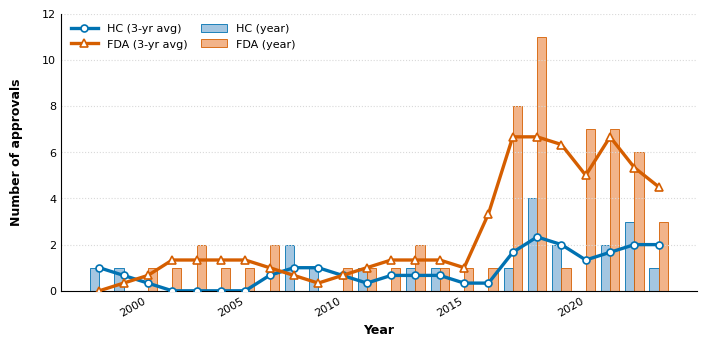

In [22]:
# Prep
def _set_publication_defaults(base_fontsize=9, font_family="DejaVu Sans"):
    # Embed TrueType fonts; many journals require this.
    mpl.rcParams.update({
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "font.size": base_fontsize,
        "font.family": font_family,
        "axes.titlesize": base_fontsize + 1,
        "axes.labelsize": base_fontsize,
        "xtick.labelsize": base_fontsize - 1,
        "ytick.labelsize": base_fontsize - 1,
        "legend.fontsize": base_fontsize - 1,
        "axes.spines.top": False,
        "axes.spines.right": False,
    })
_set_publication_defaults()

years = yearly.index.astype(int).values
x = np.arange(len(years))

# Centered 3-yr running averages
yearly['HC_3yr_avg']  = yearly['HC_pediatric'].rolling(3, center=True, min_periods=1).mean()
yearly['FDA_3yr_avg'] = yearly['FDA_pediatric'].rolling(3, center=True, min_periods=1).mean()

# Okabe–Ito base colors
hc_color  = "#0072B2"  # blue
fda_color = "#D55E00"  # vermilion

# Precomputed light tints (use instead of alpha)
hc_tint   = "#A4C6E1"  # light blue (no alpha)
fda_tint  = "#F2B48A"  # light orange (no alpha)
grid_gray = "0.85"     # solid light gray (no alpha)

# Figure
fig_width_inches = 180 / 25.4  # 180 mm width
fig, ax = plt.subplots(figsize=(fig_width_inches, fig_width_inches/2))

# Bars: yearly counts (solid tints, no transparency)
bar_width = 0.38
ax.bar(x - bar_width/2, yearly['HC_pediatric'],
       width=bar_width, color=hc_tint, edgecolor=hc_color, linewidth=0.6,
       label='HC (year)', zorder=1)
ax.bar(x + bar_width/2, yearly['FDA_pediatric'],
       width=bar_width, color=fda_tint, edgecolor=fda_color, linewidth=0.6,
       label='FDA (year)', zorder=1)

# Lines: 3-yr averages (prominent)
ax.plot(x, yearly['HC_3yr_avg'], color=hc_color, linewidth=2.4,
        marker='o', markersize=5, markerfacecolor='white', markeredgewidth=1.2,
        zorder=3, label='HC (3-yr avg)')
ax.plot(x, yearly['FDA_3yr_avg'], color=fda_color, linewidth=2.4,
        marker='^', markersize=6, markerfacecolor='white', markeredgewidth=1.2,
        zorder=3, label='FDA (3-yr avg)')

# Labels
ax.set_xlabel("Year", fontweight='bold')
ax.set_ylabel("Number of approvals", fontweight='bold')
ax.yaxis.set_label_coords(-0.06, 0.5)

# X ticks: show every 5 years
ax.set_xticks(x)
ax.set_xticklabels(years, rotation=30, ha='right')
for lab in ax.xaxis.get_ticklabels():
    if int(lab.get_text()) % 5 != 0:
        lab.set_visible(False)

# Y axis: integers only, nice ceiling
ymax = float(np.nanmax([
    yearly['HC_pediatric'].max(),
    yearly['FDA_pediatric'].max(),
    yearly['HC_3yr_avg'].max(),
    yearly['FDA_3yr_avg'].max()
]))
ax.set_ylim(0, int(np.ceil(ymax + 0.5)))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# Grid: horizontal only, solid (no alpha)
ax.grid(axis='y', linestyle=':', color=grid_gray)
ax.grid(axis='x', visible=False)

# Spines + ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)

# Legend
ax.legend(frameon=False, loc='upper left', ncol=2, columnspacing=1.2, handlelength=2.4)

plt.tight_layout()

os.makedirs("figures", exist_ok=True)
fig.savefig("figures/Figure_2.pdf",  bbox_inches="tight", pad_inches=0.01)   # vector, fonts embedded
plt.show()

## Canada-side timelines for Table 1 drugs

In [23]:
names = ["Blinatumomab", "Dinutuximab", "Tisagenlecleucel"]
rows = []
for name in names:
    sub = df[df["drug"].str.contains(name, case=False, regex=False)].copy()
    if sub.empty:
        continue
    sub["HC→CADTH_sub"] = (sub["pediatric_cadth_submission"] - sub["pediatric_hc_approval"]).dt.days
    sub["CADTH_sub→Rec"] = (sub["pediatric_cadth_recommendation"] - sub["pediatric_cadth_submission"]).dt.days
    sub["HC→Rec"] = (sub["pediatric_cadth_recommendation"] - sub["pediatric_hc_approval"]).dt.days
    rows.append(sub[["drug", "fda_indication_pediatric", "HC→CADTH_sub", "CADTH_sub→Rec", "HC→Rec"]])
res = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["drug","fda_indication_pediatric","HC→CADTH_sub","CADTH_sub→Rec","HC→Rec"])
res


,drug,fda_indication_pediatric,HC→CADTH_sub,CADTH_sub→Rec,HC→Rec
0,Blinatumomab,Ph- relapsed or refractory B-cell precursor acute lymphoblastic leukemia (ALL),-63.0,180.0,117
1,Blinatumomab,CD19-positive B-cell precursor acute lymphoblastic leukemia (ALL) in first or second complete remission with minimal residual disease,32.0,283.0,315
2,Dinutuximab,High-risk neuroblastoma,-58.0,176.0,118
3,Tisagenlecleucel,Relapsed or refractory B-cell precursor acute lymphoblastic leukemia (ALL),NaN,NaN,132


In [24]:
def build_timeline_all_rows(df: pd.DataFrame, order: str = "by_hc_approval") -> pd.DataFrame:
    # Build a timeline for ALL rows (each indication) that have an HC pediatric approval.
    cols_req = [
        "drug",
        "pediatric_hc_submission", "pediatric_hc_approval",
        "pediatric_cadth_submission", "pediatric_cadth_recommendation",
        "pediatric_pcpa_consideration", "pediatric_pcpa_negotiation_completed",
        "pediatric_fda_approval"
    ]
    missing = [c for c in cols_req if c not in df.columns]
    if missing:
        raise KeyError("Missing columns: " + ", ".join(missing))

    sub = df[df["pediatric_hc_approval"].notna()].copy()
    if sub.empty:
        raise ValueError("No rows have pediatric_hc_approval; cannot build timeline.")

    def rel(row, col):
        return (row[col] - row["pediatric_hc_approval"]).days if pd.notna(row[col]) else np.nan

    out = pd.DataFrame({
        "drug": sub["drug"].astype(str),
        "HC_submission": sub.apply(lambda r: rel(r, "pediatric_hc_submission"), axis=1),
        "CADTH_start": sub.apply(lambda r: rel(r, "pediatric_cadth_submission"), axis=1),
        "CADTH_duration": (
            (sub["pediatric_cadth_recommendation"] - sub["pediatric_cadth_submission"]).dt.days
        ),
        "pCPA_start": sub.apply(lambda r: rel(r, "pediatric_pcpa_consideration"), axis=1),
        "pCPA_duration": (
            (sub["pediatric_pcpa_negotiation_completed"] - sub["pediatric_pcpa_consideration"]).dt.days
        ),
        "FDA_approval": sub.apply(lambda r: rel(r, "pediatric_fda_approval"), axis=1),
        "_hc_approval": sub["pediatric_hc_approval"]
    })

    if order == "alphabetical":
        out = out.sort_values(["drug", "_hc_approval"], ascending=[True, True]).reset_index(drop=True)
    else:
        out = out.sort_values(["_hc_approval", "drug"], ascending=[True, True]).reset_index(drop=True)

    med = {"drug": "Median"}
    for c in ["HC_submission","CADTH_start","CADTH_duration","pCPA_start","pCPA_duration","FDA_approval"]:
        med[c] = float(out[c].median()) if out[c].notna().any() else np.nan
    med["_hc_approval"] = pd.NaT
    out = pd.concat([out, pd.DataFrame([med])], ignore_index=True)

    return out.drop(columns=["_hc_approval"])

ORDER = "alphabetical"  # or "by_hc_approval"
timeline_all = build_timeline_all_rows(df, order=ORDER)
display(timeline_all.head())


,drug,HC_submission,CADTH_start,CADTH_duration,pCPA_start,pCPA_duration,FDA_approval
0,Asparaginase erwinia chrysanthemi,NaN,NaN,NaN,NaN,NaN,4965.0
1,Blinatumomab,-256.0,-63.0,180.0,245.0,382.0,-241.0
2,Blinatumomab,-780.0,32.0,283.0,364.0,155.0,-630.0
3,Clofarabine,-434.0,NaN,NaN,NaN,NaN,-1661.0
4,Crisantaspase-recombinant,-340.0,-15.0,251.0,273.0,32.0,-429.0


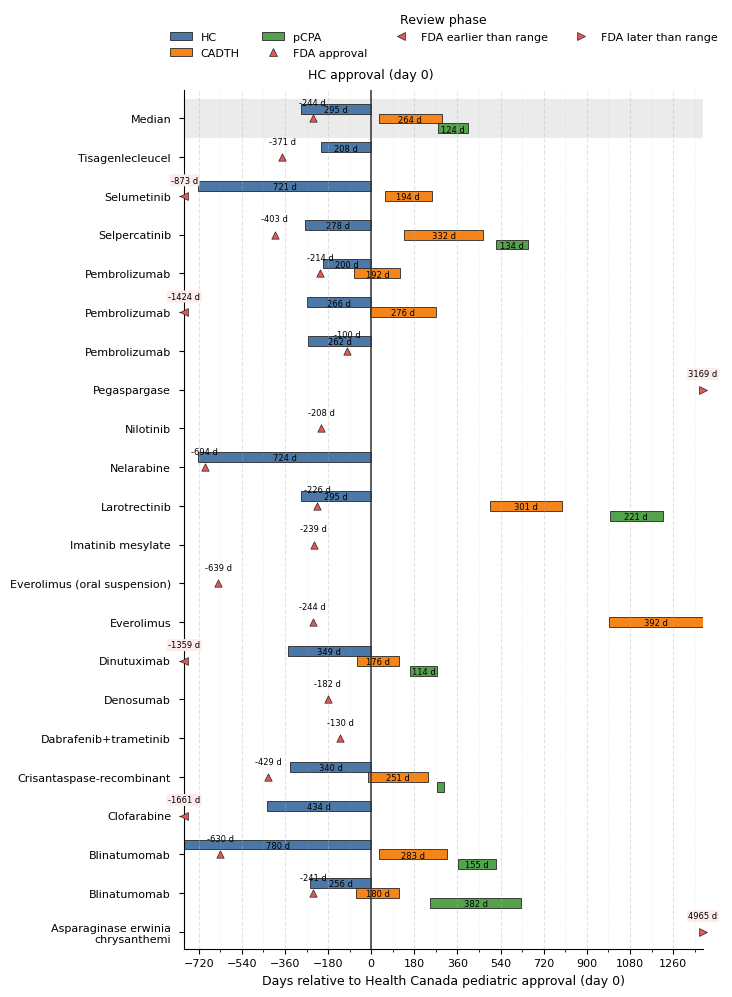

(<Figure size 669.291x1210 with 1 Axes>,
 <Axes: xlabel='Days relative to Health Canada pediatric approval (day 0)'>)

In [25]:
def plot_drug_timeline_publication(
    timeline_df: pd.DataFrame,
    min_visible=None,
    max_visible=None,
    annotate_threshold=60,     # only label bars >= this many days
    mono=False,                # monochrome + hatching for B/W
    wrap_labels_at=28,         # wrap long drug names
    highlight_median=True,
    save_basename="Figure_2",  # Wiley-style filename stem
    target_width_mm=170,       # 80–180 mm recommended
):
    _set_publication_defaults()

    # ---- figure sizing (fixed width in mm; height scales with n)
    BAR_H, PAD = 0.28, 0.26
    n = len(timeline_df)
    if n == 0:
        raise ValueError("No rows to plot.")
    height_in = max(3.2, n * 0.55)         # content-driven height in inches
    width_in  = target_width_mm / 25.4     # enforce Wiley width
    fig, ax = plt.subplots(figsize=(width_in, height_in))

    def base_y(i):
        return i * (3 * BAR_H + PAD)

    ys_hc    = np.array([base_y(i) + 2*BAR_H for i in range(n)])
    ys_cadth = np.array([base_y(i) + 1*BAR_H for i in range(n)])
    ys_pcpa  = np.array([base_y(i) + 0*BAR_H for i in range(n)])
    label_y  = np.array([base_y(i) + 1.0*BAR_H for i in range(n)])

    # ---- data
    left_hc      = timeline_df["HC_submission"].to_numpy(dtype=float)
    width_hc     = np.maximum(0, -left_hc)  # to day 0
    left_cadth   = timeline_df["CADTH_start"].to_numpy(dtype=float)
    width_cadth  = timeline_df["CADTH_duration"].to_numpy(dtype=float)
    left_pcpa    = timeline_df["pCPA_start"].to_numpy(dtype=float)
    width_pcpa   = timeline_df["pCPA_duration"].to_numpy(dtype=float)
    fda_days     = timeline_df["FDA_approval"].to_numpy(dtype=float)
    names        = timeline_df["drug"].astype(str).tolist()

    # ---- axis extents
    if min_visible is None:
        finite_left_hc = left_hc[np.isfinite(left_hc)]
        min_visible = float(np.nanmin(finite_left_hc)) if finite_left_hc.size else -365
        if not np.isfinite(min_visible): min_visible = -365
    if max_visible is None:
        ends1 = left_cadth + width_cadth
        ends2 = left_pcpa + width_pcpa
        finite_ends = np.concatenate([
            ends1[np.isfinite(ends1)],
            ends2[np.isfinite(ends2)]
        ]) if (np.isfinite(ends1).any() or np.isfinite(ends2).any()) else np.array([])
        max_visible = float(np.nanmax(finite_ends)) if finite_ends.size else 730
        if not np.isfinite(max_visible): max_visible = 730

    def clip_width(left, width):
        ok = np.isfinite(left) & np.isfinite(width)
        out = np.full_like(width, np.nan)
        out[ok] = np.maximum(0, np.minimum(width[ok], max_visible - left[ok]))
        return out

    width_hc_c    = clip_width(left_hc, width_hc)
    width_cadth_c = clip_width(left_cadth, width_cadth)
    width_pcpa_c  = clip_width(left_pcpa, width_pcpa)

    # ---- style
    if mono:
        COLORS = {"HC": "0.20", "CADTH": "0.55", "pCPA": "0.78", "FDA": "0.10"}
        HATCH  = {"HC": None, "CADTH": "//", "pCPA": ".."}
        EDGE   = "0.10"
    else:
        COLORS = {"HC": "#4C78A8", "CADTH": "#F58518", "pCPA": "#54A24B", "FDA": "#E45756"}
        HATCH  = {"HC": None, "CADTH": None, "pCPA": None}
        EDGE   = "0.15"

    # Optional highlight for the "Median" row
    if highlight_median and "Median" in names:
        i_med = names.index("Median")
        # highlight exactly the row span (3*BAR_H + PAD total height)
        row_center = base_y(i_med) + BAR_H    # center of the 3 stacked bars
        half_height = (3 * BAR_H + PAD) / 2.0
        y0 = row_center - half_height
        y1 = row_center + half_height
        ax.axhspan(y0, y1, facecolor="0.92", zorder=0)

    lw = 0.6  # edge line width for bars

    # ---- plot bars
    m = np.isfinite(left_hc) & np.isfinite(width_hc_c) & (width_hc_c > 0)
    ax.barh(ys_hc[m], width_hc_c[m], left=left_hc[m], height=BAR_H,
            color=COLORS["HC"], edgecolor=EDGE, linewidth=lw, hatch=HATCH["HC"], label="HC")

    m = np.isfinite(left_cadth) & np.isfinite(width_cadth_c) & (width_cadth_c > 0)
    ax.barh(ys_cadth[m], width_cadth_c[m], left=left_cadth[m], height=BAR_H,
            color=COLORS["CADTH"], edgecolor=EDGE, linewidth=lw, hatch=HATCH["CADTH"], label="CADTH")

    m = np.isfinite(left_pcpa) & np.isfinite(width_pcpa_c) & (width_pcpa_c > 0)
    ax.barh(ys_pcpa[m], width_pcpa_c[m], left=left_pcpa[m], height=BAR_H,
            color=COLORS["pCPA"], edgecolor=EDGE, linewidth=lw, hatch=HATCH["pCPA"], label="pCPA")

    # ---- value labels (only if wide enough)
    def annotate(left, width, ys):
        for L, W, y in zip(left, width, ys):
            if np.isfinite(L) and np.isfinite(W) and (W >= annotate_threshold):
                ax.text(L + W/2, y, f"{int(round(W))} d",
                        va="center_baseline", ha="center", fontsize=6, color="black")

    annotate(left_hc, width_hc_c, ys_hc)
    annotate(left_cadth, width_cadth_c, ys_cadth)
    annotate(left_pcpa, width_pcpa_c, ys_pcpa)

    # FDA markers (in-range + out-of-range handling)
    xmin, xmax = min_visible, max_visible
    mask = np.isfinite(fda_days)
    if mask.any():
        in_range = mask & (fda_days >= xmin) & (fda_days <= xmax)
        left_oor = mask & (fda_days <  xmin)
        right_oor= mask & (fda_days >  xmax)

        label_dy = 8  # points above the marker

        # In-range triangles + labels ABOVE the triangle
        ax.scatter(fda_days[in_range], label_y[in_range],
                s=28, marker="^", color=COLORS["FDA"],
                edgecolors=EDGE, linewidths=0.5, zorder=3)
        for x, y in zip(fda_days[in_range], label_y[in_range]):
            ax.annotate(f"{int(round(x))} d", xy=(x, y),
                        xytext=(0, label_dy), textcoords="offset points",
                        ha="center", va="bottom", fontsize=6)

        # OOR styling (solid, EPS-safe)
        pill_fc = "#FDECEC" if not mono else "0.90"
        pill_kw = dict(boxstyle="round,pad=0.18", fc=pill_fc, ec="none")

        # Left-of-range: chevron at xmin + label ABOVE
        for x, y in zip(fda_days[left_oor], label_y[left_oor]):
            ax.scatter([xmin], [y], s=32, marker="<", color=COLORS["FDA"],
                    edgecolors=EDGE, linewidths=0.5, zorder=3, clip_on=False)
            ax.annotate(f"{int(round(x))} d", xy=(xmin, y),
                        xytext=(0, label_dy), textcoords="offset points",
                        ha="center", va="bottom", fontsize=6, bbox=pill_kw, clip_on=False)

        # Right-of-range: chevron at xmax + label ABOVE (for symmetry)
        for x, y in zip(fda_days[right_oor], label_y[right_oor]):
            ax.scatter([xmax], [y], s=32, marker=">", color=COLORS["FDA"],
                    edgecolors=EDGE, linewidths=0.5, zorder=3, clip_on=False)
            ax.annotate(f"{int(round(x))} d", xy=(xmax, y),
                        xytext=(0, label_dy), textcoords="offset points",
                        ha="center", va="bottom", fontsize=6, bbox=pill_kw, clip_on=False)

        # ---- Legend (build once, here)
        handles = [
            Patch(facecolor=COLORS["HC"],   edgecolor=EDGE, linewidth=lw, hatch=HATCH["HC"],   label="HC"),
            Patch(facecolor=COLORS["CADTH"],edgecolor=EDGE, linewidth=lw, hatch=HATCH["CADTH"],label="CADTH"),
            Patch(facecolor=COLORS["pCPA"], edgecolor=EDGE, linewidth=lw, hatch=HATCH["pCPA"], label="pCPA"),
            Line2D([0],[0], marker="^", linestyle="None", color=COLORS["FDA"],
                markeredgecolor=EDGE, markeredgewidth=0.5, label="FDA approval"),
        ]
        if left_oor.any():
            handles.append(Line2D([0],[0], marker="<", linestyle="None", color=COLORS["FDA"],
                                markeredgecolor=EDGE, markeredgewidth=0.5, label="FDA earlier than range"))
        if right_oor.any():
            handles.append(Line2D([0],[0], marker=">", linestyle="None", color=COLORS["FDA"],
                                markeredgecolor=EDGE, markeredgewidth=0.5, label="FDA later than range"))

        ax.legend(handles=handles, loc="upper center",
                bbox_to_anchor=(0.5, 1.10), ncol=min(4, len(handles)),
                frameon=False, title="Review phase")


    # ---- y labels as ticks (wrapped)
    def wrap(s):
        return "\n".join(textwrap.wrap(s, width=wrap_labels_at)) if wrap_labels_at else s

    ax.set_yticks(label_y)
    ax.set_yticklabels([wrap(n) if n != "Median" else "Median" for n in names])
    ax.tick_params(axis="y", pad=6)

    # ---- axes, grids, 0‑line
    ax.set_xlim(min_visible, max_visible)
    ax.set_xlabel("Days relative to Health Canada pediatric approval (day 0)")
    ax.xaxis.set_major_locator(mticker.MultipleLocator(180))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(90))
    ax.grid(True, axis="x", which="major", linestyle="--", alpha=0.35)
    ax.grid(True, axis="x", which="minor", linestyle=":",  alpha=0.20)

    ax.set_ylim(-0.2, n * (3 * BAR_H + PAD))

    # ---- 0-line label
    ax.axvline(0, linewidth=1.1, color="0.2", zorder=2)
    ax.annotate("HC approval (day 0)", xy=(0, ax.get_ylim()[1]), xytext=(0, 6),
                textcoords="offset points", ha="center", va="bottom", fontsize=9)

    # create top margin so legend doesn’t collide with figure edge
    plt.subplots_adjust(top=0.82)

    # ---- tight layout & saves per Wiley
    os.makedirs("figures", exist_ok=True)

    fig.savefig(f"figures/{save_basename}.pdf", bbox_inches="tight", pad_inches=0.01)
    plt.show()
    return fig, ax

ORDER = "alphabetical"  # or "by_hc_approval"
timeline_all = build_timeline_all_rows(df, order=ORDER)

# Color version (for online/PDF):
plot_drug_timeline_publication(timeline_all, mono=False, save_basename="Figure_3")